In [108]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [67]:
def read_data(index):
    train = pd.read_csv('data/{:02d}_train.csv'.format(index))
    train_x = train.iloc[:, :-1].to_numpy()
    train_y = train.iloc[:, -1].to_numpy()
    test = pd.read_csv('data/{:02d}_test.csv'.format(index))
    test_x = test.iloc[:, :-1].to_numpy()
    test_y = test.iloc[:, -1].to_numpy()
    return train_x, train_y, test_x, test_y

In [140]:
class DatasetObject:
    def __init__(self, features = None, y = None):
        self.features = features
        self.y = y

class GiniCalculator:
    def __init__(self, objects = None):
        self.gini_sum = 0
        self.objects_amount = 0
        if (objects is not None):
            self.objects_amount = len(objects)
        self.map_class_to_amount = {}
        if (objects == None):
            return
        for elem in objects:
            self.update_map(elem.y, True)
        for k, v in self.map_class_to_amount.items():
            self.gini_sum += pow(v, 2)

    def update_map(self, y, isLeft):
        if (isLeft):
            if (y in self.map_class_to_amount):
                self.map_class_to_amount[y] = self.map_class_to_amount[y] + 1
            else:
                self.map_class_to_amount[y] = 1
        else:
            self.map_class_to_amount[y] = self.map_class_to_amount[y] - 1

    def update_as_left(self, y):
        self.gini_sum -= pow(self.map_class_to_amount.get(y, 0), 2)
        self.update_map(y, True)
        self.gini_sum += pow(self.map_class_to_amount.get(y, 0), 2)
        self.objects_amount = self.objects_amount + 1

    def update_as_right(self, y):
        self.gini_sum -= pow(self.map_class_to_amount.get(y, 0), 2)
        self.update_map(y, False)
        self.gini_sum += pow(self.map_class_to_amount.get(y, 0), 2)
        self.objects_amount = self.objects_amount - 1

    def get_gini(self):
        if (self.objects_amount == 0):
            return 1.0
        else:
            return 1.0 - self.gini_sum / pow(self.objects_amount, 2)

class Node:
    def __init__(self, objects = None):
        self.root = None
        self.objects = objects
        self.left = None
        self.right = None
        self.clazz = None
        self.parent = None
        self.val = None
        self.feature_id = None
        
    def isLeaf(self):
        return self.left == None and self.right == None
    
    def build_children(self, feature_id, feature_val):
        leftElems = []
        rightElems = []
        for elem in self.objects:
            if (elem.features[feature_id] < feature_val):
                leftElems.append(elem)
            else:
                rightElems.append(elem)
        self.left = Node(leftElems)
        self.right = Node(rightElems)
        self.left.parent = self
        self.right.parent = self
    
class DecisionTree:
    def __init__(self, h=None):
        self.h = 7
        self.X = None
        self.Y = None
        self.objects = []
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.features_num = len(X[0])
        self.objects_num = len(X)
        for i in range(self.objects_num):
            cur_object = DatasetObject(X[i], Y[i])
            self.objects.append(cur_object)
        return self.build_tree(self.objects)
    
    def __predict(self, node, x):
        if (node.left == None):
            return node.clazz
        if x[node.feature_id] < node.val:
            return self.__predict(node.left, x)
        else:
            return self.__predict(node.right, x)
    
    def predict(self, x):
        return self.__predict(self.root, x)
        
    def predict_all(self, X):
        res = []
        for i in range(len(X)):
            res.append(self.predict(X[i]))
        res = [-1 if v is None else v for v in res]
        return res
        
    def build_tree(self, objects):
        root = Node(objects)
        self.root = root
        return self.build_tree_inner(root, 1)
    
    def is_same_objects(self, objects):
        first_y = objects[0].y
        for elem in objects:
            if (elem.y != first_y):
                return False
        return True
        
    def build_tree_inner(self, node, depth):
        if (len(node.objects) == 0):
            node.clazz = node.parent.clazz
            return
        if (self.is_same_objects(node.objects)):
            node.clazz = node.objects[0].y
            return
        if (self.h is not None and depth > self.h):
            node.clazz = self.get_most_common_class(node.objects)
        else:
            best_feature_id, best_feature_val = self.get_best_feature(node.objects)
            node.build_children(best_feature_id, best_feature_val)
            node.feature_id = best_feature_id
            node.val = best_feature_val
            self.build_tree_inner(node.left, depth + 1)
            self.build_tree_inner(node.right, depth + 1)

    def get_most_common_class(self, objects):
        y = [elem.y for elem in objects]
        return max(set(y), key=y.count)

    def get_best_feature(self, objects):
        gini_min = 100000
        best_feature_id = -1
        best_feature_val = -1
        obj_num = len(objects)
        for feature_id in range(self.features_num):
            #sort by feature id
            objects.sort(key = lambda cur_object: cur_object.features[feature_id])
            left_calc = GiniCalculator(None)
            right_calc = GiniCalculator(objects)
            for j in range(obj_num - 1):
                cur_object = objects[j]
                next_object = objects[j + 1]
                cur_val = (cur_object.features[feature_id] + next_object.features[feature_id]) / 2.0
                left_calc.update_as_left(cur_object.y)
                right_calc.update_as_right(cur_object.y)
                cur_gini = (left_calc.objects_amount / obj_num) * left_calc.get_gini() + (right_calc.objects_amount / obj_num) * right_calc.get_gini()
                #cur_gini = self.count_split_gini(objects, j)
                if (cur_gini < gini_min):
                    gini_min = cur_gini
                    best_feature_id = feature_id
                    best_feature_val = cur_val
        return best_feature_id, best_feature_val
    
    def count_split_gini(self, objects, split_pos):
        obj_len = len(objects)
        left_obj_num = split_pos + 1
        right_obj_num = obj_len - left_obj_num
        right_gini = self.calc_gini_index(objects[left_obj_num:obj_len])
        left_gini = self.calc_gini_index(objects[0:left_obj_num])
        return (left_obj_num / obj_len) * left_gini + (right_obj_num / obj_len) * right_gini
    
    def calc_gini_index(self, objects):
        class_to_amount = {}
        obj_num = len(objects)
        for elem in objects:
            if (elem.y in class_to_amount):
                class_to_amount[elem.y] = class_to_amount[elem.y] + 1
            else:
                class_to_amount[elem.y] = 1
        gini_index = 0.0
        for k, v in class_to_amount.items():
            gini_index += pow(v / obj_num, 2)
        return 1 - gini_index

In [71]:
for index in range(1, 22):
    train_x, _, _, _ = read_data(index)
    print(train_x.shape)

(3891, 9)
(3930, 100)
(2074, 93)
(2875, 98)
(462, 10)
(1812, 100)
(2150, 94)
(481, 91)
(510, 45)
(2485, 12)
(2485, 14)
(3563, 7)
(1090, 91)
(2591, 85)
(1665, 38)
(3210, 93)
(1791, 91)
(1343, 92)
(1333, 13)
(2524, 6)
(1577, 7)


In [72]:
best_heights = []
for index in range(1, 22):
    train_x, train_y, test_x, test_y = read_data(index)
    best_h = -1
    best_score = -1
    for h in range (1, 12):
        tree = DecisionTree(h)
        tree.fit(train_x, train_y)
        predicted_y = tree.predict_all(test_x)
        cur_score = accuracy_score(test_y, predicted_y)
        if (cur_score > best_score):
            best_score = cur_score
            best_h = h
    best_heights.append(best_h)
    print('best h for dataset %d is %d with accuracy = %f' % (index, best_h, best_score))

best h for dataset 1 is 3 with accuracy = 0.999486
best h for dataset 2 is 9 with accuracy = 0.644784
best h for dataset 3 is 1 with accuracy = 1.000000
best h for dataset 4 is 5 with accuracy = 0.990609
best h for dataset 5 is 1 with accuracy = 0.995671
best h for dataset 6 is 3 with accuracy = 0.992274
best h for dataset 7 is 3 with accuracy = 0.995814
best h for dataset 8 is 2 with accuracy = 0.997921
best h for dataset 9 is 5 with accuracy = 0.815686
best h for dataset 10 is 4 with accuracy = 0.993561
best h for dataset 11 is 1 with accuracy = 0.999195
best h for dataset 12 is 7 with accuracy = 0.866966
best h for dataset 13 is 7 with accuracy = 0.627523
best h for dataset 14 is 6 with accuracy = 0.956773
best h for dataset 15 is 1 with accuracy = 1.000000
best h for dataset 16 is 1 with accuracy = 1.000000
best h for dataset 17 is 7 with accuracy = 0.815187
best h for dataset 18 is 5 with accuracy = 0.934475
best h for dataset 19 is 7 with accuracy = 0.807952
best h for dataset 20

In [100]:
sort_indices = np.argsort(best_heights)
min_dataset_index = sort_indices[0]
max_dataset_index = sort_indices[-1]
mid_dataset_index = sort_indices[len(sort_indices) // 2]
print('min h is dataset - %d with h = %d' % (min_dataset_index, best_heights[min_dataset_index]))
print('max h is dataset - %d with h = %d' % (max_dataset_index, best_heights[max_dataset_index]))
print('mid h is dataset - %d with h = %d' % (mid_dataset_index, best_heights[mid_dataset_index]))

min h is dataset - 10 with h = 1
max h is dataset - 1 with h = 9
mid h is dataset - 8 with h = 5


In [105]:
def draw_h_accurancy_dependency(dataset_index, title):
    train_x, train_y, test_x, test_y = read_data(dataset_index + 1)
    train_accuracy_scores = []
    test_accuracy_scores = []
    heights = range(1, 12)
    for h in heights:
        tree = DecisionTree(h)
        tree.fit(train_x, train_y)
        predicted_y_test = tree.predict_all(test_x)
        predicted_y_train = tree.predict_all(train_x)
        cur_score_test = accuracy_score(predicted_y_test, test_y)
        cur_score_train = accuracy_score(predicted_y_train, train_y)
        
        train_accuracy_scores.append(cur_score_train)
        test_accuracy_scores.append(cur_score_test)
    
    plt.title(title)
    plt.plot(heights, train_accuracy_scores, label='train dataset')
    plt.plot(heights, test_accuracy_scores, label='test dataset')
    plt.xlabel('Высота дерева')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

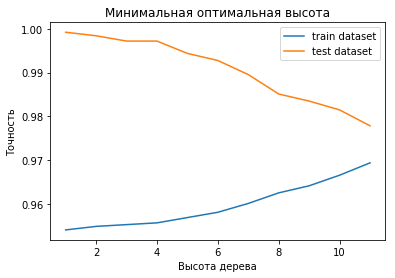

In [102]:
draw_h_accurancy_dependency(min_dataset_index, "Минимальная оптимальная высота")

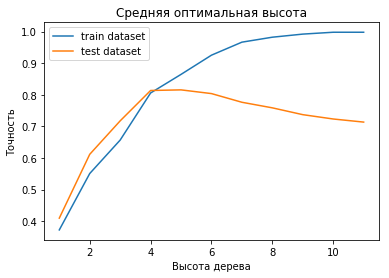

In [103]:
draw_h_accurancy_dependency(mid_dataset_index, "Средняя оптимальная высота")

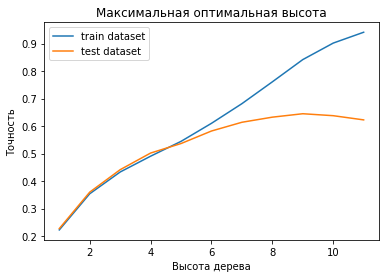

In [104]:
draw_h_accurancy_dependency(max_dataset_index, "Максимальная оптимальная высота")

In [135]:
class RandomForest:
    def __init__(self, trees_num, is_random_objects):
        self.trees_num = trees_num
        self.is_random_objects = is_random_objects
        self.trees = []
        
    def __get_random_objects(self, X, y, new_size):
        n = len(X)
        new_X = []
        new_y = []
        for i in range(new_size):
            index = random.randint(0, n - 1)
            new_X.append(X[index])
            new_y.append(y[index])
        return new_X, new_y
    
    def __get_random_features(self, X, new_size):
        n = len(X[0])
        indices = []
        for _ in range(new_size):
            indices.append(random.randint(0, n - 1))
        return [[x[i] for i in indices] for x in X]
    
    def fit(self, X, y):
        for i in range(self.trees_num):
            tree = DecisionTree()
            random_X, random_y = X, y
            if (self.is_random_objects):
                random_X, random_y = self.__get_random_objects(X, y, int(np.sqrt(len(X))))
            else:
                random_X = self.__get_random_features(X, int(np.sqrt(len(X[0]))))
            tree.fit(random_X, random_y)
            self.trees.append(tree)
    def predict(self, X):
        vote_num = {}
        for tree in self.trees:
            pred_val = tree.predict(X)
            if (pred_val in vote_num):
                vote_num[pred_val] = vote_num[pred_val] + 1
            else:
                vote_num[pred_val] = 1
        return max(vote_num, key=vote_num.get)
    
    def predict_all(self, X):
        res = []
        for i in range(len(X)):
            res.append(self.predict(X[i]))
        res = [-1 if v is None else v for v in res]
        return res

In [142]:
tree_scores = []
random_forest_features_scores = []
random_forest_objects_scores = []
for index in range(1, 22):
    train_x, train_y, test_x, test_y = read_data(index)
    tree = DecisionTree(7)
    tree.fit(train_x, train_y)
    rand_features_forest = RandomForest(7, False)
    rand_features_forest.fit(train_x, train_y)
    rand_objects_forest = RandomForest(7, True)
    rand_objects_forest.fit(train_x, train_y)
    tree_res = accuracy_score(tree.predict_all(test_x), test_y)
    features_forest_res = accuracy_score(rand_features_forest.predict_all(test_x), test_y)
    objects_forest_res = accuracy_score(rand_objects_forest.predict_all(test_x), test_y)
    tree_scores.append(tree_res)
    random_forest_features_scores.append(features_forest_res)
    random_forest_objects_scores.append(objects_forest_res)
    print('Tree res for dataset %d is %f' % (index, tree_res))
    print('Feature forest res for dataset %d is %f' % (index, features_forest_res))
    print('Object forest res for dataset %d is %f' % (index, objects_forest_res))

Tree res for dataset 1 is 0.992033
Feature forest res for dataset 1 is 0.354922
Object forest res for dataset 1 is 0.987664
Tree res for dataset 2 is 0.613740
Feature forest res for dataset 2 is 0.135369
Object forest res for dataset 2 is 0.139440
Tree res for dataset 3 is 0.990357
Feature forest res for dataset 3 is 0.864995
Object forest res for dataset 3 is 0.999518
Tree res for dataset 4 is 0.979478
Feature forest res for dataset 4 is 0.502957
Object forest res for dataset 4 is 0.838609
Tree res for dataset 5 is 0.982684
Feature forest res for dataset 5 is 0.922078
Object forest res for dataset 5 is 0.969697
Tree res for dataset 6 is 0.982340
Feature forest res for dataset 6 is 0.382450
Object forest res for dataset 6 is 0.933775
Tree res for dataset 7 is 0.978140
Feature forest res for dataset 7 is 0.354884
Object forest res for dataset 7 is 0.843721
Tree res for dataset 8 is 0.993763
Feature forest res for dataset 8 is 0.787942
Object forest res for dataset 8 is 0.970894
Tree res

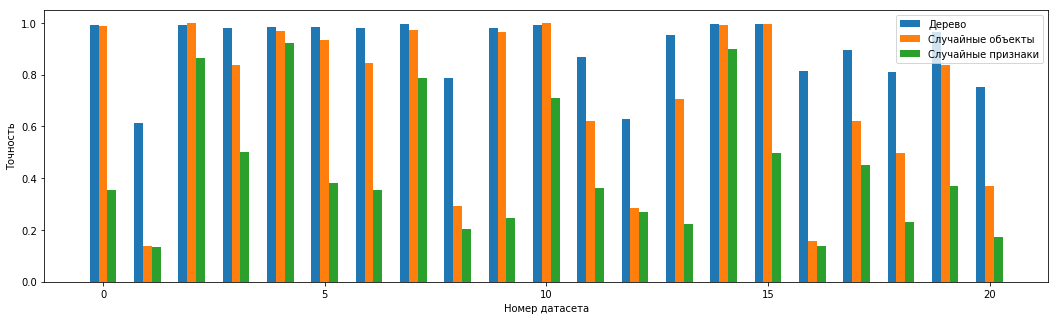

In [152]:
width = 0.2
datasets = np.array(range(21))
f, ax = plt.subplots(figsize=(18,5))
plt.bar(datasets - width, tree_scores, label='Дерево', width=width)
plt.bar(datasets, random_forest_objects_scores, label='Случайные объекты', width=width)
plt.bar(datasets + width, random_forest_features_scores, label='Случайные признаки', width=width)
plt.xlabel('Номер датасета')
plt.ylabel('Точность')
plt.legend()
plt.show()